In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import musicalrobot
import pickle

from scipy.interpolate import BSpline
from scipy.signal import find_peaks

In [2]:
from musicalrobot import edge_detection as ed
from musicalrobot import pixel_analysis as pa
from musicalrobot import post_data

In [3]:
frames = ed.input_file('../musicalrobot/data/8_15_19_Dodecanoic_acid.tiff')

In [4]:
len(frames)

743

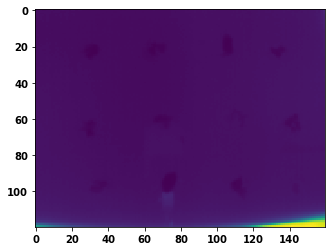

In [5]:
plt.imshow(frames[0])

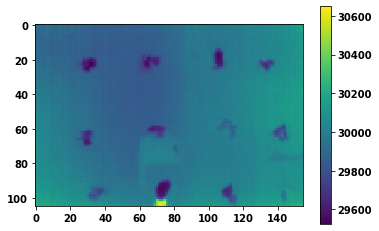

In [6]:
crop_frame = []
for frame in frames:
    crop_frame.append(frame[0:105,0:155])
plt.imshow(crop_frame[0])
plt.colorbar()

In [9]:
flip_frames = ed.flip_frame(crop_frame)

In [10]:
labeled_samples = ed.edge_detection(flip_frames)

In [11]:
regprops = ed.regprop(labeled_samples, flip_frames, 12, 3, 4)

In [7]:
flip_frames, regprops, s_temp, p_temp, inf_temp, m_df= ed.inflection_temp(crop_frame,12,3,4)

In [8]:
m_df

,Row,Column,Melting point
unique_index,,,
15.0,5.0,10.0,46.97
53.0,41.0,12.0,30.23
101.0,81.0,20.0,47.33
48.0,6.0,42.0,40.19
86.0,44.0,42.0,43.48
132.0,84.0,48.0,47.51
88.0,8.0,80.0,44.59
126.0,43.0,83.0,46.20
169.0,82.0,87.0,44.94


In [9]:
list(regprops[4]['Mean Intensity'])[4]

29953.0

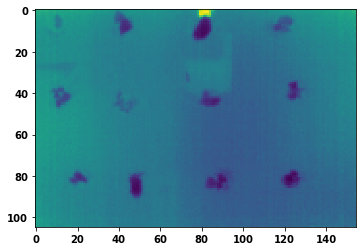

In [10]:
plt.imshow(flip_frames[0])

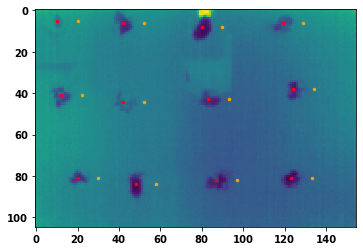

In [11]:
plt.imshow(flip_frames[0])
plt.scatter(regprops[0]['Plate_coord'],regprops[0]['Row'],c='orange',s=6)
plt.scatter(regprops[0]['Column'],regprops[0]['Row'],s=6,c='red')
# plt.title('Sample centroid and plate locations at which the temperature is monitored')

In [13]:
regprops[1]

,Row,Column,Plate,Plate_coord,Area,Perim,Mean Intensity
unique_index,,,,,,,
15.0,5.0,10.0,30142.0,20.0,24.0,16.000000,29982.0
53.0,41.0,12.0,30085.0,22.0,74.0,30.142136,29968.0
101.0,81.0,20.0,30052.0,30.0,43.0,23.313708,29697.0
48.0,6.0,42.0,30054.0,52.0,64.0,28.727922,29694.0
86.0,44.0,42.0,30013.0,52.0,78.0,37.556349,29916.0
132.0,84.0,48.0,29980.0,58.0,60.0,27.899495,29577.0
88.0,8.0,80.0,29982.0,90.0,91.0,40.349242,29568.0
126.0,43.0,83.0,29864.0,93.0,60.0,29.071068,29667.0
169.0,82.0,87.0,29835.0,97.0,66.0,29.899495,29736.0


In [14]:
np.mean(inf_temp)

44.26083333333333

In [15]:
inf_temp

[46.97,
 30.23,
 47.33,
 40.19,
 43.48,
 47.51,
 44.59,
 46.2,
 44.94,
 46.27,
 48.92,
 44.5]

In [16]:
x = np.linspace(1,len(s_temp[0]),len(s_temp[0]))

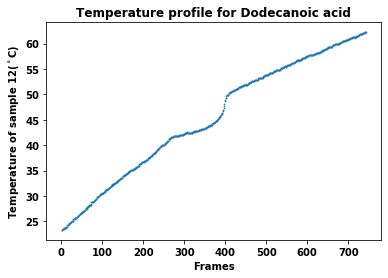

In [36]:
plt.scatter(x,s_temp[10],s=0.5)
plt.xlabel('Frames')
plt.ylabel('Temperature of sample 12($^\circ$C)')
plt.title('Temperature profile for Dodecanoic acid')
plt.show()
# plt.scatter(x,p_temp[3],s=1.5)


In [38]:
# To save the temperature profiles of the samples as a pickle file
with open('../../inf_temp.pkl','wb') as handle:
    pickle.dump(s_temp, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [39]:
def inflection_point(s_temp,p_temp):
    s_infl = []
    p_infl = []
    s_peaks = []
    p_peaks = []
    inf_peak = [] ; inf_temp = []
    for temp in s_temp:
        frames = np.linspace(1,len(temp),len(temp))
        # Fitting a spline to the temperature profile of the samples.
        bspl = BSpline(frames,temp,k=3)
        # Stacking x and y to calculate gradient.
        gradient_array = np.column_stack((frames,bspl(frames)))
        # Calculating gradient.
        gradient = np.gradient(gradient_array,axis=0)
        # Calculating derivative
        derivative = gradient[:,1]/gradient[:,0]
        # Finding peaks in the derivative plot.
        peaks, properties = find_peaks(derivative,height=0.1)
        max_height1 = np.max(properties['peak_heights'])
        # To find the second highest peak
        a = list(properties['peak_heights'])
        a.remove(max_height1)
        max_height2 = np.max(a)
        # Appending the index of the two highest peaks to lists.
        inf_index1 = list(properties['peak_heights']).index(max_height1)
        inf_index2 = list(properties['peak_heights']).index(max_height2)
        # Appending the frame number in which these peaks occur to a list
        s_peaks.append([peaks[inf_index1],peaks[inf_index2]])
        # Appending the temperature at the peaks.
        s_infl.append([temp[peaks[inf_index1]],temp[peaks[inf_index2]]])
    for temp in p_temp:
        frames = np.linspace(1,len(temp),len(temp))
        bspl = BSpline(frames,temp,k=3)
        gradient_array = np.column_stack((frames,bspl(frames)))
        gradient = np.gradient(gradient_array,axis=0)
        derivative = gradient[:,1]/gradient[:,0]
        peaks, properties = find_peaks(derivative,height=0.1)
        max_height1 = np.max(properties['peak_heights'])
        # To find the second highest peak
        a = list(properties['peak_heights'])
        a.remove(max_height1)
        max_height2 = np.max(a)
        inf_index1 = list(properties['peak_heights']).index(max_height1)
        inf_index2 = list(properties['peak_heights']).index(max_height2)
        p_peaks.append([peaks[inf_index1],peaks[inf_index2]])
        p_infl.append([temp[peaks[inf_index1]],temp[peaks[inf_index2]]])
    for i,peaks in enumerate(s_peaks):
        for peak in peaks:
            if abs(peak - p_peaks[i][0]) >= 3:
                inf_peak.append(peak)
                break
            else:
                pass
    for i,temp in enumerate(s_temp):
        inf_temp.append(temp[inf_peak[i]])
    return inf_temp, s_peaks, p_peaks

In [19]:

inf_temp, s_peaks, p_peaks = inflection_point(s_temp,p_temp)

In [20]:
s_peaks

[[292, 288],
 [40, 57],
 [375, 371],
 [249, 413],
 [254, 109],
 [461, 466],
 [439, 443],
 [333, 16],
 [307, 35],
 [317, 43],
 [399, 395],
 [395, 294]]

In [21]:
p_peaks

[[78, 66],
 [78, 35],
 [70, 66],
 [67, 95],
 [79, 50],
 [11, 19],
 [79, 25],
 [9, 79],
 [113, 137],
 [277, 79],
 [67, 8],
 [121, 86]]